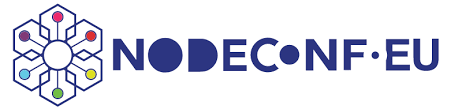

# Creating machine learning model for gesture detection

Hi, this is the Google Colab for the NodeConfEU 2019 Bangle.js workshop. This document will help you understand how the built-in machine learning model for detecting gestures works and also allow you to extend the model with your own gestures. No understanding of machine learning is required and if you get stuck we are here to help.

## Introduction

The gesture recognition works by measure acceleration via the accelerometer that is built into the watch. This acceleration is relative to the watch and does therefore not provide an exact way to measure position, for example, relative to your head. However, it is still possible to recognize a few simple gestures.

The watch comes with a set of pre-trained gesture:
* swipeleft: an arc on the left side.
* swiperight: an arc on the right side.
* upup: hand moving up in two steps.
* waggle: rotating the arm side to side.
* clap2: two claps with the hands.

The firmware also attempts to filter out steady motion, to save power. Additionally, there is a `random` gesture which is for undefined hand moments, such as scratching your head.

All of these pre-trained gestures may not suit you, as they make assumptions about speed, movement, if the watch is on the right or left hand, etc.. However, using this document you will be able to understand how the model is created and create your own model that fits your movements and needs.

_Note, if you are a bit familiar with machine learning we encourage you to develop your own model. But note that the memory and compute capabilities of the watch are very limited. The model's total size should not exceed 20kb. There are also many limitations to what "TensorFlow 2.0 TFLite for Microprocessors" can do. But more on that later._

### How to run the code

Everything is ready, all you need to do is **press Runtime -> Run all**. You can also take it step-by-step, by clicking the ( ▶) button on the left of each code section. Note that set variables remain set, even if you execute previous code, which can sometimes cause issues. To reset the session press _Runtime -> Restart Runtime_.

## Setup - that you should not spend time on

You shouldn't spend much time on this part. This is just to setup your Colab. What is does is:

* Set the TensorFlow version to be 2.x, otherwise it will be 1.x.
* Clone our GitHub repository, that you can also find at https://github.com/nearform/nodeconfeu-gesture-models.git
* Install all dependencies, including the special `nodeconfeu_watch` module, which you will help you load the data, evaluate the model, and export the model.

In [ ]:
%tensorflow_version 2.x

In [2]:
!rm -rf sample_data nodeconfeu-gesture-models
!git clone https://github.com/conoro/nodeconfeu-gesture-models.git
!mkdir -p exports

Cloning into 'nodeconfeu-gesture-models'...
remote: Enumerating objects: 824, done.
remote: Counting objects: 100% (824/824), done.
remote: Compressing objects: 100% (436/436), done.
remote: Total 824 (delta 455), reused 731 (delta 363), pack-reused 0
Receiving objects: 100% (824/824), 1.26 MiB | 583.00 KiB/s, done.
Resolving deltas: 100% (455/455), done.


In [3]:
!cd nodeconfeu-gesture-models && pip install .

Processing /Users/conoroneill/gitwork/nodewatch-2019/nodeconfeu-gesture-models/nodeconfeu-gesture-models
     |████████████████████████████████| 716kB 323kB/s eta 0:00:01


  Created wheel for nodeconfeu-watch: filename=nodeconfeu_watch-0.1.0-cp37-none-any.whl size=2015 sha256=5c03375bcdf41d394bdf2325dc654d92f439d9181c5fd2b8c81c891ca8fb0b25
  Stored in directory: /Users/conoroneill/Library/Caches/pip/wheels/6f/49/5a/884d527d629aa3645af91ba13bc03437f81532f4c1a1467412
Successfully built nodeconfeu-watch
  Found existing installation: nodeconfeu-watch 0.1.0
    Uninstalling nodeconfeu-watch-0.1.0:
      Successfully uninstalled nodeconfeu-watch-0.1.0


# Introduction

## Dataset

The goal is to be able to recognize hand gestures by measuring the acceleration from the builtin watch accelerometer. This can be quite challenging as there a correlation between the acceleration and the gesture is not very obvious. To understand this challenge better, we start by looking at the acceleration for different gestures.

The `AccelerationReader` loads the dataset, this will be discussed in more detail later.

In [4]:
from nodeconfeu_watch.reader import AccelerationReader

dataset = AccelerationReader({
        "conor": ['./nodeconfeu-gesture-models/data/conor-v2', './nodeconfeu-gesture-models/data/conor-extra']
},
    test_ratio=0.2, validation_ratio=0.2,
    classnames=['singleladies', 'swiperight', 'swipeleft', 'upup', 'waggle', 'clap2', 'random'])

dataset_df = dataset.dataframe() # This variable is just for plotting

In [6]:
#@title
import altair as alt
import numpy as np

alt.Chart(
    dataset_df[
      np.logical_and(
          dataset_df['subset'] == 'validation',
          dataset_df['person'] == 'conor'
      )
    ],
    width=200
).mark_line(
    opacity=0.4
).encode(
    x='time:Q',
    y='acceleration:Q',
    detail='id:N',
    color='label:N',
    column='dimension:N'
).interactive(bind_y=False)

alt.Chart(...)

The above plot, clearly shows that there is some difference  between each gesture. However, it is not clear how to accurately quantify this difference into something meaningful. To solve this problem machine learning is used.

### Understanding the data format

Each observation is a row in CSV file, for example:

```
swiperight(14), 2,-20,-22,0,-34,-25,0,-24,-27,2,-25,-26,0,-23,-23,0,-23,-23,-3,-23,-23,-11,-41,-14,-9,-40,8,3,-56,21,45,-29,1,14,15,-27,4,-15,-29,0,-26,-29
```

The observations are accelerometer data in `(x,y,z)` coordinates measured with 0.1 seconds interval. A typical gesture is between 1 and 2 seconds long. Meaning 10 to 15 samples.

The `AccelerationReader` will read this format and change it into a 2d-array, with (x, y, z) as columns and samples as rows. This format is useful for the convolutional neural network which will be used later. An example of this is displayed below.

_All observations are extended to have 50 samples, where missing samples are set to have acceleration `0`. You can set `max_sequence_length` in `AccelerationReader` to change this behavior._

In [7]:
#@title
import pandas as pd
display(pd.DataFrame(dataset.train.x[0, 0:20, 0, :], columns=['x', 'y', 'z']))

,x,y,z
0,62.0,14.0,8.0
1,62.0,25.0,6.0
2,64.0,28.0,25.0
3,61.0,4.0,26.0
4,55.0,-12.0,-8.0
5,55.0,-6.0,-18.0
6,59.0,4.0,-13.0
7,59.0,15.0,-3.0
8,62.0,35.0,19.0
9,62.0,12.0,27.0


Plotting this data looks like the following:

In [8]:
#@title
import altair as alt
import pandas as pd

alt.Chart(
    pd.DataFrame(
        dataset.train.x[0, :, 0, :],
        columns=['x', 'y', 'z']
    ).assign(
        time = np.arange(0, 5, 0.1)
    ),
    width=600
).transform_fold(
    ['x', 'y', 'z'],
    as_=['dimension', 'acceleration']
).mark_line(
).encode(
    x='time:Q',
    y='acceleration:Q',
    color='dimension:N'
).interactive(bind_y=False)

alt.Chart(...)

### Adding your own gesture

To train with your own gestures you need to modify the `AccelerationReader`. For example, to add add the `swipeup` event from the `extra` dataset:

```python
dataset = AccelerationReader({
        "james": ['./nodeconfeu-gesture-models/data/james-v2'],
        "conor": ['./nodeconfeu-gesture-models/data/conor-v2'],
        "extra": ['./nodeconfeu-gesture-models/data/extra-v2'] # added extra dataset
    },
    test_ratio=0.2, validation_ratio=0.2,
    classnames=['swiperight', 'swipeleft', 'swipeup', 'upup', 'waggle', 'clap2', 'random']) # added 'swipeup'
```

_Note: The `extra` dataset, is just to get you started. You should record your own data and use that instead of `extra`._

### Remarks about cultural bias

Describing a gesture isn't always straight forward. While we might think that something as simple as clapping is universally understood, it too is affected by our culture, environment, situation, etc.. Therefore while James and Conor both clapped with the watch on the left hand while sitting down, there is a significant difference in the data (see figure below).

When trying out the model or when training it with your own data, it is therefore important to be aware of these differences. Either communicate the gestures precisely or even better try and collaborate with others to make a dataset that encompasses these differences.

In [9]:
#@title
import altair as alt

# plot the acceleration data
alt.Chart(
    dataset_df[
      np.logical_and(
          dataset_df['subset'] == 'validation',
          dataset_df['label'] == 'clap2'
      )
    ],
    width=200
).mark_line(
    opacity=0.4
).encode(
    x='time:Q',
    y='acceleration:Q',
    detail='id:N',
    color='person:N',
    column='dimension:N'
).interactive(bind_y=False)

alt.Chart(...)

### Splitting the dataset

You should now have a reasonable understanding of the data format and the challenges creating a model that can correlate the acceleration data with a particular gesture. However, before diving in to TensorFlow and the model, it is critial to understand how data should be split. Otherwise you may end up with a false belief that your model is good.

A dataset in machine learning is always split up into at least 3 parts:

1. A training dataset, used for learning the model.
2. A validation dataset, used for making decisions about the model, such as the number of parameters or how it is optimized.
3. A test dataset, used when you really think the model is good and you want to evaluate how it would perform on data that have never been seen before, by the model or by you!

The `AccelerationReader` constructor parses the CSV data and generates these three datasets. `test_ratio` and `validation_ratio` controls how much data is put aside for validation and testing. The datasets are exposed as `dataset.train`, `dataset.validation`, and `dataset.test`.

_Note that this uses [statified sampling](https://en.wikipedia.org/wiki/Stratified_sampling), meaning `validation_ratio=0.2` takes 20% for each gesture type and not just from the entire dataset. This is relevant when there is not an equal amount of observations for each gesture._

## Introduction to TensorFlow

TensorFlow is a framework for operating with tensors, which are just fixed-sized multidimensional arrays. Such an operation could be adding each element together, for example `[1,2] + [3,4] = [4,6]` or summing all elements, such as `[1,2] = 3`. However, TensorFlow's capabilities extend far beyond these simple operations. In particular, it provides essential mathematical tools for optimizing models, such as computing gradients.

For defining the model, the [keras framework](https://keras.io/) is used. This is a high-level framework on top of TensorFlow which makes it easy to define common neural networks, while still allowing the user to implement custom components. For this workshop, only predefined components are used.

### TensorFlow Lite for Microcontrollers

While there are popular alternatives to TensorFlow such as [PyTorch](https://pytorch.org/), TensorFlow provides capabilities useful for the industry that other frameworks have not yet prioritized. One such example is ["TensorFlow Lite for Microcontrollers"](https://www.tensorflow.org/lite/microcontrollers), which is what allows us to run models on Microcontrollers such as the smartwatch badge.

Without going into too many details, TensorFlow Lite allows us to export the model loosely compressed (called quantization) and save it to a flatbuffer format. This file can then be used to evaluate the model in a microcontroller, using the ["TensorFlow Lite for Microcontrollers"](https://www.tensorflow.org/lite/microcontrollers) library. This is a small C++ library that doesn't depend on an operating system, thereby allowing us to use it on the smartwatch.

## Define model

When creating a model for an embedded device, it is important to keep things simple as this the total-size should not exceed 20kb, which is not a lot for a contemporary neural network.

The model used here, is a simple [convolutional neural network](https://en.wikipedia.org/wiki/Convolutional_neural_network) \([easy blog post](https://victorzhou.com/blog/intro-to-cnns-part-1/)). The central idea is to first learn micro-patterns, such as right movement, left movement, or sudden stop. Then learn macro-patterns such as a right movement, followed by a sudden stop, followed by a left movement, then a right movement again, and finally a sudden stop, may indicate a clap.

Both the micro and macro patterns are looked for over time, and at each time step, it outputs some signal of this pattern being detected. To summarize this, the model then looks for the strongest signal (MaxPool) over time.

This gives a 1 dimensional array of values, each one indicating either a gesture or a significant part of a gesture. To then scale and combine these values, such they can attain a probabilistic meaning, a final transformation (Dense) is applied.

In [1]:
#@title
%%html
<svg version="1.1" viewBox="0 0 410.01 194.07" width="350" xmlns="http://www.w3.org/2000/svg">
 <g transform="matrix(1.5284 0 0 1.5284 -814.5 -430.73)">
  <g transform="matrix(.61712 0 0 .61712 207.54 107.91)">
   <g stroke="#000">
    <g stroke-width="1.9">
     <rect class="rect" x="543" y="363" width="1" height="50" fill="#a0a0a0" opacity=".8"/>
     <rect class="rect" x="552" y="372" width="1" height="50" fill="#e0e0e0" opacity=".8"/>
     <rect class="rect" x="561" y="381" width="1" height="50" fill="#a0a0a0" opacity=".8"/>
     <rect class="rect" x="609" y="313.5" width="1" height="46" fill="#a0a0a0" opacity=".8"/>
     <rect class="rect" x="618" y="322.5" width="1" height="46" fill="#e0e0e0" opacity=".8"/>
     <rect class="rect" x="627" y="331.5" width="1" height="46" fill="#a0a0a0" opacity=".8"/>
     <rect class="rect" x="636" y="340.5" width="1" height="46" fill="#e0e0e0" opacity=".8"/>
     <rect class="rect" x="645" y="349.5" width="1" height="46" fill="#a0a0a0" opacity=".8"/>
     <rect class="rect" x="654" y="358.5" width="1" height="46" fill="#e0e0e0" opacity=".8"/>
     <rect class="rect" x="663" y="367.5" width="1" height="46" fill="#a0a0a0" opacity=".8"/>
     <rect class="rect" x="672" y="376.5" width="1" height="46" fill="#e0e0e0" opacity=".8"/>
     <rect class="rect" x="681" y="385.5" width="1" height="46" fill="#a0a0a0" opacity=".8"/>
     <rect class="rect" x="690" y="394.5" width="1" height="46" fill="#e0e0e0" opacity=".8"/>
     <rect class="rect" x="699" y="403.5" width="1" height="46" fill="#a0a0a0" opacity=".8"/>
     <rect class="rect" x="708" y="412.5" width="1" height="46" fill="#e0e0e0" opacity=".8"/>
     <rect class="rect" x="717" y="421.5" width="1" height="46" fill="#a0a0a0" opacity=".8"/>
     <rect class="rect" x="726" y="430.5" width="1" height="46" fill="#e0e0e0" opacity=".8"/>
     <rect class="rect" x="766" y="354" width="1" height="46" fill="#e0e0e0" opacity=".8"/>
     <rect class="rect" x="775" y="363" width="1" height="46" fill="#a0a0a0" opacity=".8"/>
     <rect class="rect" x="784" y="372" width="1" height="46" fill="#e0e0e0" opacity=".8"/>
     <rect class="rect" x="793" y="381" width="1" height="46" fill="#a0a0a0" opacity=".8"/>
     <rect class="rect" x="802" y="390" width="1" height="46" fill="#e0e0e0" opacity=".8"/>
    </g>
    <g stroke-opacity=".8">
     <rect class="conv" x="561" y="401.85" width="1" height="5" fill-opacity="0" stroke-width="1.9"/>
     <rect class="conv" x="726" y="436.74" width="1" height="9" fill-opacity="0" stroke-width="1.9"/>
     <line class="link" x1="562" x2="726.66" y1="406.85" y2="451.82" stroke-width=".95"/>
     <line class="link" x1="562" x2="726.66" y1="401.85" y2="451.82" stroke-width=".95"/>
    </g>
    <polygon class="poly" points="880.95 374.97 870.95 374.97 866 370.03 876 370.03" fill="#e0e0e0" opacity=".8" stroke-width="1.9"/>
    <polygon class="poly" transform="translate(61.771)" points="887.9 374.97 882.95 370.03 892.95 370.03 897.9 374.97" fill="#e0e0e0" opacity=".8" stroke-width="1.9"/>
    <line class="line" x1="880.95" x2="950" y1="374.97" y2="374.97" stroke-opacity=".8" stroke-width=".95"/>
    <line class="line" x1="876.64" x2="944.64" y1="370.03" y2="370.03" stroke-opacity=".8" stroke-width=".95"/>
   </g>
   <g font-family="sans-serif" font-size="16px">
    <text class="text" x="600" y="481" dy="0.34999999em">Conv2D</text>
    <text class="text" x="740.75" y="481" dy="0.34999999em">Conv2D</text>
    <text class="text" x="823.11694" y="481" dy="5.5999999">MaxPool</text>
    <text class="info" x="526.03632" y="348" dy="-4.8000002">3@50x1</text>
    <text class="info" x="604.75903" y="298.5" dy="-4.8000002">14@46x1</text>
    <text class="info" x="752.75903" y="330">5@46x1</text>
    <text class="info" x="863.87952" y="355.02512" dy="-4.8000002">1x5</text>
    <text class="info" x="931.31934" y="355.02512" dy="-4.8000002">1x5</text>
    <text class="text" x="903.69458" y="486.6001">Dense</text>
   </g>
   <g fill="none" stroke="#000" stroke-width="1.0602px">
    <path d="m803 390 67.95-15.025" stroke-opacity=".8"/>
    <path d="m767 354 99 16.025" stroke-opacity=".8"/>
    <path d="m727 445.74 76.144-46.615-76.144 37.615" stroke-opacity=".8"/>
   </g>
  </g>
 </g>
</svg>

SyntaxError: invalid syntax (<ipython-input-1-47a8cc4b92a8>, line 3)

In [11]:
import tensorflow as tf
import tensorflow.keras as keras

tf.random.set_seed(1)

model = keras.Sequential()
# Define input
model.add(keras.Input(shape=(50, 1, 3), name='acceleration'))
# Define first convolution layer (detects micro patterns)
# You can experiment with 14, 5, and activation here.
model.add(keras.layers.Conv2D(14, (5, 1),
                              padding='valid', activation='relu'))
model.add(keras.layers.Dropout(0.2))
# Define second convolution layer (detects macro patterns)
# You can experiment with 5, 2, and activation here. `len(dataset.classnames)`
#   can also be changed to someting larger than `len(dataset.classnames)`.
model.add(keras.layers.Conv2D(len(dataset.classnames), (5, 1),
                              padding='same', activation='relu', dilation_rate=2))
model.add(keras.layers.Dropout(0.1))

# Define the sequence summarization layer
# The number 46 is meant to compass the entire sequence, which is now 46 long,
#   this is computed as `dataset.max_sequence_length - (micro_filter_width - 1)`.
#   Where micro_filter_width is the `5` in the first convolution layer.
# Normally one should use `keras.layers.GlobalMaxPool2D()` which does the same,
#   however that is not yet supported by TFLite Micro.
model.add(keras.layers.MaxPool2D((46, 1)))
model.add(keras.layers.Flatten())

# Define the final layer that outputs classes.
# The input needs to be len(dataset.classnames).
model.add(keras.layers.Dense(len(dataset.classnames), use_bias=False))

# Compile the model, this defines how the model is optimizied
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

### Training model

The model is then learned on the `dataset.train` dataset using `model.fit`. A validation dataset (`dataset.validation`) is also used. This dataset is not directly used to optimize the model, and therefore represents new data as you would get when deploying the model.

Disgusting these datasets are essential, as a model can easily just memoize what exact input corresponds to a gesture, instead of learning meaningful patterns, this is called [overfitting](https://en.wikipedia.org/wiki/Overfitting). The behavior that we want to prevent is that accuracy on the training dataset keeps increasing, but the accuracy on the validation dataset starts to decrease.

The model here is designed to prevent overfitting. However, if you change the model parameters you may encounter these issues. A simple solution is to set the `epochs` (how many times the model sees the same data) to where the model performed the best on the validation dataset.

_Note, if you want to see more details set `verbose=1` and consider removing `callbacks=[KerasLivePlot()]`._

In [12]:
from nodeconfeu_watch.visual import KerasLivePlot

history = model.fit(dataset.train.x, dataset.train.y,
                    batch_size=64,
                    epochs=200,
                    verbose=0,
                    validation_data=(dataset.validation.x, dataset.validation.y),
                    callbacks=[KerasLivePlot()])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Evaluate model

There is not a single way to [measure the quality of a model](https://en.wikipedia.org/wiki/Precision_and_recall). Precision can get a high score by under-classifying, and recall can get a high score by over-classifying. The F1-score attempts to achieve the best of both worlds.

If you are looking for a high-quality model, a high F1-score is a reasonable metric. The precision and recall may provide you additional information on why the F1-score is not high.

The default model and dataset should give you an F1-score of approximately 96-99%.

In [13]:
from nodeconfeu_watch.visual import classification_report

print(classification_report(model, dataset, subset='validation'))

              precision    recall  f1-score   support

singleladies     0.0000    0.0000    0.0000         5
  swiperight     1.0000    1.0000    1.0000         8
   swipeleft     1.0000    1.0000    1.0000         8
        upup     1.0000    1.0000    1.0000         8
      waggle     0.5000    1.0000    0.6667         5
       clap2     0.8000    1.0000    0.8889         8
      random     1.0000    0.7500    0.8571         8

    accuracy                         0.8600        50
   macro avg     0.7571    0.8214    0.7732        50
weighted avg     0.8180    0.8600    0.8260        50



/Users/conoroneill/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Export model

To run the model on the watch, you need to export the model to the TFLite format, this is a [flatbuffer schema](https://google.github.io/flatbuffers/) defined in [`tensorflow/lite/schema/`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/schema/schema.fbs). While this format [supports many operations](https://www.tensorflow.org/lite/guide/ops_compatibility), TFLite for Microcontrollers does not support that many operations. The `ExportModel` abstraction attempts to assert these restrictions for you, but you may encounter additional issues if you use alternative layers in the model definition.

### Not-quantized exporting

The simplest approach to exporting the model is to just export the model as is. However, this does waste some space as models use `float32` weights. This normal and not a big issue when executing models in the cloud, however when executing models on a microprocessor size matters and floating-point operations typically takes many CPU-cycles to compute. To reduce the size and improve computation speed, a model is therefore typically quantized.

In [ ]:
from nodeconfeu_watch.convert import ExportModel

exporter_raw = ExportModel(model, dataset, quantize=False)
print(classification_report(model, dataset, subset='test'))
print(exporter_raw.size_report())
exporter_raw.save('exports/model_not_quantized.tflite')

### Quantized exporting

Quantizing converting floating-point weights to something more categorical in this case an `int8`. This conversion is more complicated than just casting the value, as the weights may be outside of the `int8` range; `[-127,127]`. This conversion can reduce accuracy, but the model usually remains quite accurate.

You can read more about the process here, in the [tensorflow documentation](https://www.tensorflow.org/lite/performance/post_training_quantization#representation_for_quantized_tensors), as well as [the TensorFlow paper on quantization](https://arxiv.org/abs/1712.05877).

In [ ]:
from nodeconfeu_watch.convert import ExportModel

exporter_quant = ExportModel(model, dataset, quantize=True)
print(classification_report(model, dataset, subset='test'))
print(exporter_quant.size_report())
exporter_quant.save('exports/model_quantized.tflite')

### Transfer the model to your Bangle.js

Finally, you can upload the model to your watch. The easiest way is to run the code below and paste its output into the Left-Hand-Side REPL in the Espruino Wed IDE whilst its connected to the Bangle.js. Alternatively you can download it from the `exports/` directory.

In [ ]:
print(f'require("Storage").write("tfmodel",atob("{exporter_quant.base64()}"));')